<br><br>
<font size='6'><b>Autoencoder
</b></font><br><br>

<table style="border-style: hidden; border-collapse: collapse;" width = "80%"> 
    <tr style="border-style: hidden; border-collapse: collapse;">
        <td width = 60% style="border-style: hidden; border-collapse: collapse;">

        </td>
        <td width = 20%>
        By Prof. Seungchul Lee<br>iSystems Design Lab<br>http://isystems.unist.ac.kr/<br>UNIST
        </td>
    </tr>
</table>

Table of Contents
<div id="toc"></div>

# 1. Unsupervised Learning

__ Definition __
- Unsupervised learning refers to most attempts to extract information from a distribution that do not require human labor to annotate example
- Main task is to find the 'best' representation of the data

__ Dimension Reduction __
- Attempt to compress as much information about $x$ as possible in a smaller representation
- Preserve as much information about $x$ as possible while obeying some constraint aimed at keeping the representation simpler

<br>
<img src="./image_files/dim_reduction.png" width = 400>
<br>

# 2. Autoencoders

- It is like 'deep learning version' of unsupervised learning

__Definition__
- An autoencoder is a neural network that is trained to attempt to copy its input to its output
- The network consists of two parts: an encoder function and a decoder that produces a reconstruction

<br>
<img src="./image_files/autoencoder_before.png" width = 600>
<br>

<br>
<img src="./image_files/autoencoder_cat.png" width = 600>
<br>

__ Encoder and Decoder __
- Encoder function : $h = f(x)$
- Decoder function : $r = g(h)$
- We learn to set $g\left(f(x)\right) = x$

__ Modern Autoencoders __
- Beyond deterministic functions to stochastic mapping: $p_{\text{encoder}}(h\mid x)$ and $p_{\text{decoder}}(x\mid h)$
    - Variabtional autoencoder (VAE)
    - Generative adversarial nerwork (GAN)


- Will not cover them in this tutorial

<br>
<img src="./image_files/autoencoder_gaussian.png" width = 800>
<br>

# 3. Autoencoder with TensorFlow

- MNIST example
- Use only (1, 5, 6) digits to visualize in 2-D

<br>
<img src="./image_files/AE_arch.png" width = 800>

## 3.1. Import Library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

## 3.2. Load MNIST Data

In [2]:
def batch_maker(batch_size, img, label):
    img_len = len(img)
    random_idx = np.random.randint(img_len, size = batch_size)
    return img[random_idx], label[random_idx]

In [3]:
from six.moves import cPickle

mnist = cPickle.load(open('./data_files/MNIST.pkl', 'rb'))
train_idx = ((np.argmax(mnist.train.labels, 1) == 1) | \
             (np.argmax(mnist.train.labels, 1) == 5) | \
             (np.argmax(mnist.train.labels, 1) == 6))
test_idx = ((np.argmax(mnist.test.labels, 1) == 1) | \
            (np.argmax(mnist.test.labels, 1) == 5) | \
            (np.argmax(mnist.test.labels, 1) == 6))

trainimgs   = mnist.train.images[train_idx]
trainlabels = mnist.train.labels[train_idx]
testimgs    = mnist.test.images[test_idx]
testlabels  = mnist.test.labels[test_idx]
n_train      = trainimgs.shape[0]
n_test       = testimgs.shape[0]
print ("Packages loaded")
print ("The number of trainimgs : {}, shape : {}".format(n_train, trainimgs.shape))
print ("The number of testimgs : {}, shape : {}".format(n_test, testimgs.shape))

Packages loaded
The number of trainimgs : 16583, shape : (16583, 784)
The number of testimgs : 2985, shape : (2985, 784)


## 3.3. Define an Autoencoder Shape
- Input shape and latent variable shape
- Encoder shape
- Decoder shape

In [4]:
# Shape of input and latent variable
n_input = 28*28

# Encoder shape
n_ehidden1 = 500
n_ehidden2 = 300

n_z = 2

# Decoder shape
n_dhidden1 = 300
n_dhidden2 = 500

## 3.4. Define Weights and Biases
- Define weights and biases for encoder and decoder, separately
- Based on the predefied layer size
- Initialize with normal distribution with $\mu=0$ and $\sigma=0.01$

In [5]:
encoder_weights = {
    'eh1_w' : tf.Variable(tf.random_normal([n_input, n_ehidden1], stddev=0.01)),
    'eh2_w' : tf.Variable(tf.random_normal([n_ehidden1, n_ehidden2], stddev=0.01)),
    'eh3_w' : tf.Variable(tf.random_normal([n_ehidden2, n_z], stddev=0.01))
}
encoder_biases = {
    'eh1_b' : tf.Variable(tf.random_normal([n_ehidden1], stddev=0.01)),
    'eh2_b' : tf.Variable(tf.random_normal([n_ehidden2], stddev=0.01)),
    'eh3_b' : tf.Variable(tf.random_normal([n_z], stddev=0.01))
}

In [6]:
decoder_weights = {
    'dh1_w' : tf.Variable(tf.random_normal([n_z, n_dhidden1], stddev=0.01)),
    'dh2_w' : tf.Variable(tf.random_normal([n_dhidden1, n_dhidden2], stddev=0.01)),
    'dh3_w' : tf.Variable(tf.random_normal([n_dhidden2, n_input], stddev=0.01))
}
decoder_biases = {
    'dh1_b' : tf.Variable(tf.random_normal([n_dhidden1], stddev=0.01)),
    'dh2_b' : tf.Variable(tf.random_normal([n_dhidden2], stddev=0.01)),
    'dh3_b' : tf.Variable(tf.random_normal([n_input], stddev=0.01))
}

## 3.5. Build a Model
__Encoder__
- Simple ANN (MLP) model
- Use $tanh$ for nonlinear activation function
- $z$ is not applied with nonlinear activation function

__Decoder__
- Simple ANN (MLP) model
- Use $tanh$ for nonlinear activation function
- $\hat{x}$ is not applied with nonlinear activation function

<br>
<img src="./image_files/autoencoder2.jpg" width = 700>

In [7]:
def encoder(x, weights, biases):
    ehidden1 = tf.matmul(x, weights['eh1_w']) + biases['eh1_b']
    ehidden1 = tf.nn.relu(ehidden1)
    
    ehidden2 = tf.matmul(ehidden1, weights['eh2_w']) + biases['eh2_b']
    ehidden2 = tf.nn.relu(ehidden2)
    
    z = tf.matmul(ehidden2, weights['eh3_w']) + biases['eh3_b']
    return z

In [8]:
def decoder(z, weights, biases):
    dhidden1 = tf.matmul(z, weights['dh1_w']) + biases['dh1_b']
    dhidden1 = tf.nn.relu(dhidden1)
    
    dhidden2 = tf.matmul(dhidden1, weights['dh2_w']) + biases['dh2_b']
    dhidden2 = tf.nn.relu(dhidden2)
    
    x = tf.matmul(dhidden2, weights['dh3_w']) + biases['dh3_b']
    return x

## 3.6. Define Loss, Initializer and Optimizer

__Loss__
- Squared loss
$$  \frac{1}{N}\sum_{i=1}^{N} (t_{i} - y_{i})^2 $$

__Initializer__
- Initialize all the empty variables
    
__Optimizer__
- AdamOptimizer: The most popular optimizer

In [9]:
learning_rate = 0.0001
x = tf.placeholder(tf.float32, [None, n_input])

z = encoder(x, encoder_weights, encoder_biases)
x_hat = decoder(z, decoder_weights, decoder_biases)
cost = tf.reduce_mean(tf.square(x - x_hat))

optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

init = tf.global_variables_initializer()

## 3.7. Summary of Model

<img src="./image_files/rnn_summary of model.png" width = 500>

## 2.8. Define Configuration
- Define parameters for training autoencoder
     - Batch size: batch size for stochastic gradient descent
     - The number of iteration: the number of training steps
     - Flag: check cost for every flag iteration

In [10]:
batch_size = 500
n_iter = 10000
flag = 500

## 2.9. Optimization

Do not run during the tutorial.

In [11]:
# Run initialize
sess = tf.Session()
sess.run(init)

# Training cycle
for epoch in range(n_iter):
    batch_x, batch_y = batch_maker(batch_size, trainimgs, trainlabels)
    sess.run(optimizer, feed_dict={x: batch_x})  
    
    if epoch % flag == 0:
        c = sess.run(cost, feed_dict={x: batch_x})
        print ("Iter : {}".format(epoch))
        print ("Cost : {}".format(c))

Iter : 0
Cost : 0.09386688470840454
Iter : 500
Cost : 0.04464731365442276
Iter : 1000
Cost : 0.03645443916320801
Iter : 1500
Cost : 0.03173022344708443
Iter : 2000
Cost : 0.031199540942907333
Iter : 2500
Cost : 0.031380411237478256
Iter : 3000
Cost : 0.029163440689444542
Iter : 3500
Cost : 0.02748207002878189
Iter : 4000
Cost : 0.02882632240653038
Iter : 4500
Cost : 0.027712849900126457
Iter : 5000
Cost : 0.02730368822813034
Iter : 5500
Cost : 0.02701018936932087
Iter : 6000
Cost : 0.027452386915683746
Iter : 6500
Cost : 0.027454838156700134
Iter : 7000
Cost : 0.027391724288463593
Iter : 7500
Cost : 0.027591053396463394
Iter : 8000
Cost : 0.027708856388926506
Iter : 8500
Cost : 0.0269516259431839
Iter : 9000
Cost : 0.026356227695941925
Iter : 9500
Cost : 0.02474367246031761


## 2.10. Test
__ Test Reconstruction Performance __
- To check validity of autoencoder

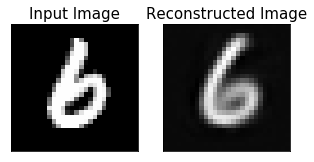

In [12]:
test_x, test_y = batch_maker(1, trainimgs, trainlabels)
x_reconst = sess.run(x_hat, feed_dict={x : test_x})

fig = plt.figure(figsize=(5, 3))
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(test_x.reshape(28, 28), 'gray')
ax1.set_title('Input Image', fontsize=15)
ax1.set_xticks([])
ax1.set_yticks([])

ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(x_reconst.reshape(28, 28), 'gray')
ax2.set_title('Reconstructed Image', fontsize=15)
ax2.set_xticks([])
ax2.set_yticks([])
plt.show()

__ Test Distribution of Latent Variable __
- We project 784-dimensional image to 2-dimensional space

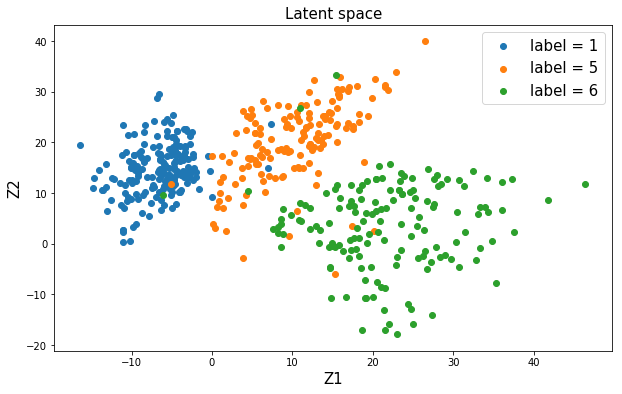

In [13]:
test_x, test_y = batch_maker(500, trainimgs, trainlabels)
test_y = np.argmax(test_y, axis=1)
test_z = sess.run(z, feed_dict={x : test_x})

plt.figure(figsize=(10,6))
plt.scatter(test_z[test_y == 1, 0], test_z[test_y == 1, 1], label = 'label = 1')
plt.scatter(test_z[test_y == 5, 0], test_z[test_y == 5, 1], label = 'label = 5')
plt.scatter(test_z[test_y == 6, 0], test_z[test_y == 6, 1], label = 'label = 6')
plt.title('Latent space', fontsize=15)
plt.xlabel('Z1', fontsize=15)
plt.ylabel('Z2', fontsize=15)
plt.legend(fontsize = 15)
plt.show()

__ Data Generation __

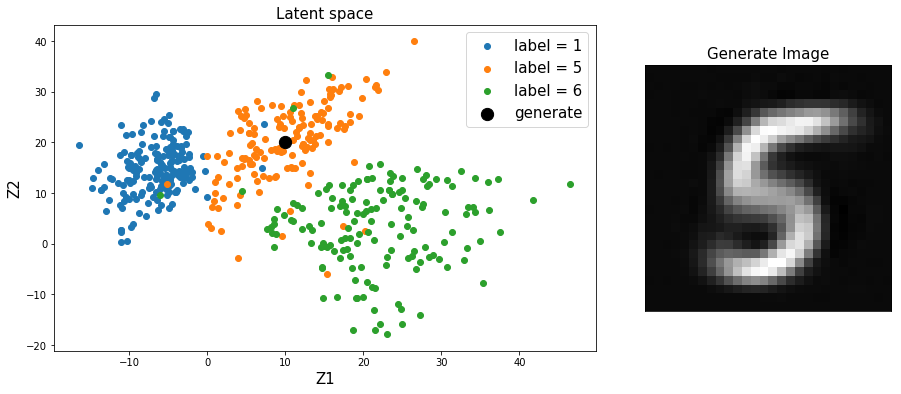

In [18]:
generate_data = np.array([[10, 20]])

fig = plt.figure(figsize=(15,6))
ax = plt.subplot2grid((1,3), (0,0), colspan=2)
ax.scatter(test_z[test_y == 1, 0], test_z[test_y == 1, 1], label = 'label = 1')
ax.scatter(test_z[test_y == 5, 0], test_z[test_y == 5, 1], label = 'label = 5')
ax.scatter(test_z[test_y == 6, 0], test_z[test_y == 6, 1], label = 'label = 6')
ax.scatter(generate_data[:, 0], generate_data[:, 1], label = 'generate', s = 150, c = 'k', marker = 'o')
ax.set_title('Latent space', fontsize=15)
ax.set_xlabel('Z1', fontsize=15)
ax.set_ylabel('Z2', fontsize=15)
ax.legend(fontsize = 15)

z_input = tf.placeholder(tf.float32, [None, n_z])
reconst = decoder(z_input, decoder_weights, decoder_biases)
generate_x = sess.run(reconst, feed_dict={z_input : generate_data})


ax = plt.subplot2grid((1,3), (0,2), colspan=1)
ax.imshow(generate_x.reshape(28, 28), 'gray')
ax.set_title('Generate Image', fontsize=15)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

# 3. Visualization

__Image Generation__

- Select an arbitrary latent varibale $z$
- Generate images using the learned decoder

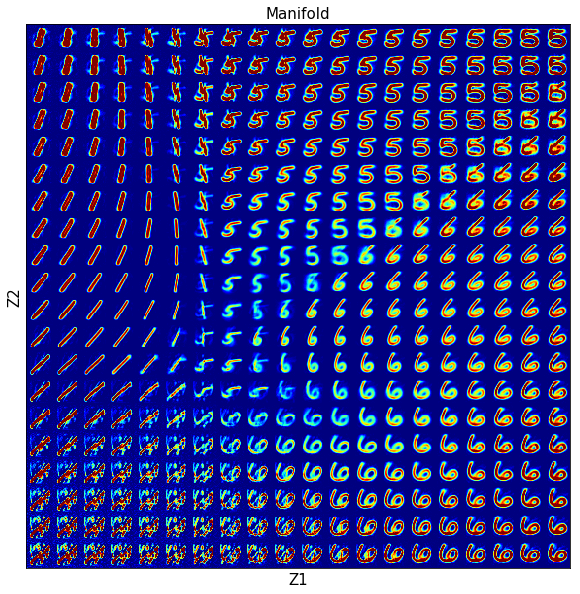

In [17]:
# Initialize canvas
nx = ny = 20
x_values = np.linspace(-30, 50, nx)
y_values = np.linspace(-20, 40, ny)
canvas = np.empty((28*ny, 28*nx))

# Define placeholder
z_input = tf.placeholder(tf.float32, [None, n_z])
reconst = decoder(z_input, decoder_weights, decoder_biases)

for i, yi in enumerate(x_values):
        for j, xi in enumerate(y_values):
            z_ = np.array([[xi, yi]])
            reconst_ = sess.run(reconst, feed_dict={z_input : z_})
            canvas[(nx - i - 1)*28:(nx - i)*28, j*28:(j + 1)*28] = reconst_.reshape(28,28)

plt.figure(figsize=(10, 10))
plt.imshow(canvas, clim=(0,1), cmap=plt.cm.jet)
plt.title('Manifold', fontsize=15)
plt.xticks([])
plt.xlabel('Z1', fontsize=15)
plt.yticks([])
plt.ylabel('Z2', fontsize=15)
plt.show()

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>